
https://www.thelancet.com/journals/lanpsy/article/PIIS2215-0366(20)30171-1/fulltext

https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/bulletins/deathsrelatedtodrugpoisoninginenglandandwales/previousReleases

In [1]:
#import libraries
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
sql = '''WITH
bnf_tab AS (
SELECT
DISTINCT chemical,
chemical_code
FROM
ebmdatalab.hscic.bnf )
SELECT
rx.month,
rx.pct,
SUBSTR(rx.bnf_code,1,9) AS chemical_code,
chemical,
sum(items) AS total_items,
sum(actual_cost) as total_cost
FROM
hscic.normalised_prescribing_standard AS rx
LEFT JOIN
bnf_tab
ON
chemical_code =SUBSTR(rx.bnf_code,1,9)
JOIN
  hscic.ccgs AS ccgs
ON
rx.pct=ccgs.code
WHERE
  (bnf_code LIKE "0403%" OR ##antidepressants
  bnf_code LIKE "0407010%%" OR ##analgesics
  bnf_code LIKE "0402%") ##antipsychotics
  AND
  bnf_code NOT LIKE "0407010B0%"
  AND
  ccgs.org_type='CCG'
GROUP BY
rx.month,
rx.pct,
chemical_code,
chemical
ORDER BY
month'''

df_poisoning = bq.cached_read(sql, csv_path=os.path.join('..','data','overall_poisoning.csv'))
df_poisoning['month'] = df_poisoning['month'].astype('datetime64[ns]')
df_poisoning.head(3)

,month,pct,chemical_code,chemical,total_items,total_cost
0,2010-08-01,99C,0403010B0,Amitriptyline Hydrochloride,3803,7472.51
1,2010-08-01,01D,0403010B0,Amitriptyline Hydrochloride,3318,7693.68
2,2010-08-01,03A,0407010F0,Co-Codamol (Codeine Phos/Paracetamol),4347,20312.49


In [3]:
df_poisoning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262487 entries, 0 to 1262486
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   month          1262487 non-null  datetime64[ns]
 1   pct            1262487 non-null  object        
 2   chemical_code  1262487 non-null  object        
 3   chemical       1262487 non-null  object        
 4   total_items    1262487 non-null  int64         
 5   total_cost     1262487 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 57.8+ MB


In [4]:
df_poisoning["chemical"].unique()

array(['Amitriptyline Hydrochloride',
       'Co-Codamol (Codeine Phos/Paracetamol)', 'Dosulepin Hydrochloride',
       'Duloxetine Hydrochloride', 'Olanzapine', 'Quetiapine',
       'Risperidone', 'Nefopam Hydrochloride', 'Mirtazapine',
       'Nortriptyline', 'Venlafaxine', 'Paracetamol',
       'Co-Proxamol (Dextroprop HCl/Paracet)', 'Lithium Carbonate',
       'Valproic Acid', 'Escitalopram', 'Chlorpromazine Hydrochloride',
       'Amisulpride', 'Haloperidol', 'Flupentixol Hydrochloride',
       'Sertraline Hydrochloride', 'Paroxetine Hydrochloride',
       'Citalopram Hydrobromide', 'Clomipramine Hydrochloride',
       'Fluoxetine Hydrochloride', 'Promazine Hydrochloride',
       'Paracetamol Combined Preparations', 'Perphenazine',
       'Lofepramine Hydrochloride', 'Zuclopenthixol Hydrochloride',
       'Fluvoxamine Maleate', 'Trifluoperazine',
       'Zuclopenthixol Decanoate', 'Trazodone Hydrochloride',
       'Co-Dydramol (Dihydrocodeine/Paracet)',
       'Paracetamol & Pheny

(0, 10721089.3)

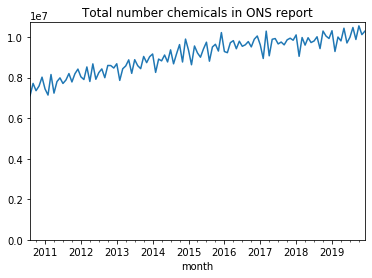

In [5]:
df_poisoning.groupby("month")['total_items'].sum().plot(kind='line', title="Total number chemicals in ONS report")
plt.ylim(0, )

In [6]:
sql2 = """
SELECT
  month,
  pct_id AS pct,
  SUM(total_list_size) AS list_size
FROM
  ebmdatalab.hscic.practice_statistics
GROUP BY
  month,
  pct
ORDER BY
  month,
  pct,
  list_size
"""
df_list = bq.cached_read(sql2, csv_path=os.path.join('..','data','list_size.csv'))
df_list['month'] = df_list['month'].astype('datetime64[ns]')
df_list.head(3)

,month,pct,list_size
0,2015-01-01,NaN,0
1,2015-01-01,00C,106673
2,2015-01-01,00D,288824


In [7]:
ccg_total = df_poisoning.groupby(["month", "pct"])["total_items"].sum().reset_index()
ccg_total.head()

,month,pct,total_items
0,2010-08-01,00C,19212
1,2010-08-01,00D,62046
2,2010-08-01,00J,46316
3,2010-08-01,00K,47334
4,2010-08-01,00L,58366


In [8]:
poisoning_ccg_1000 = pd.merge(ccg_total, df_list, on=['month', 'pct'])
poisoning_ccg_1000['items_per_1000'] = 1000* (poisoning_ccg_1000['total_items']/poisoning_ccg_1000['list_size'])
poisoning_ccg_1000.head(3)

,month,pct,total_items,list_size,items_per_1000
0,2015-01-01,00C,24303,106673,227.827098
1,2015-01-01,00D,85074,288824,294.553084
2,2015-01-01,00J,64690,252951,255.741231


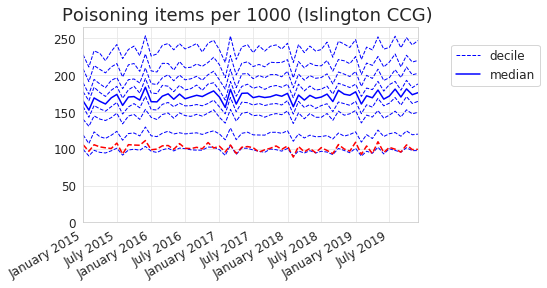

In [10]:
#create sample deciles & prototype measure
charts.deciles_chart(
        poisoning_ccg_1000,
        period_column='month',
        column='items_per_1000',
        title="Poisoning items per 1000 (Islington CCG) ",
        show_outer_percentiles=False)

#add in example CCG (Islington)
df_subject = poisoning_ccg_1000.loc[poisoning_ccg_1000['pct'] == '08H']
plt.plot(df_subject['month'], df_subject['items_per_1000'], 'r--')

plt.show()

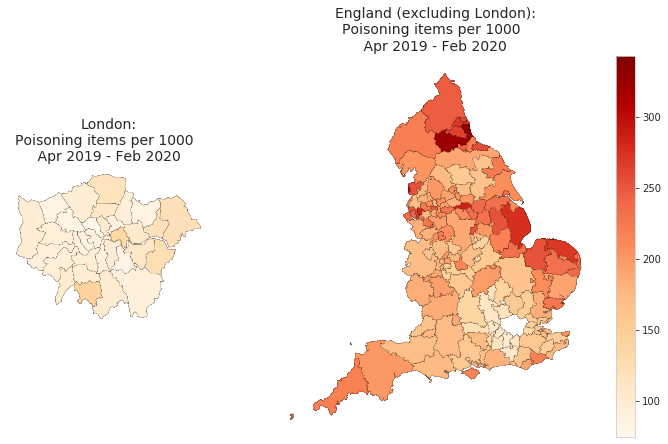

In [12]:

#create choropeth map of cost per 1000 patients
plt.figure(figsize=(12, 7))
latest_poisoning_df_1000 = poisoning_ccg_1000.loc[(poisoning_ccg_1000['month'] >= '2019-04-01') & (poisoning_ccg_1000['month'] <= '2020-02-01')]
plt = maps.ccg_map(latest_poisoning_df_1000, title="Poisoning items per 1000  \n Apr 2019 - Feb 2020 ", column='items_per_1000', separate_london=True)
plt.show()